# Identify working and data directory and site ID.
* The working directory is the root directory of the github.
* The data directory points to the google drive folder where the larger data files are stored.
* For the moment the site ID if the four-digit NEON site ID.

In [1]:
working<-"~/neon_suna"
site_id<-"CARI"
data<-paste("~/gdrive/SUNA_Data/SUNA_NEON/",site_id,"/",sep="")


# Initialize required libraries, functions and formatting utilities.

In [2]:
library(dplyr)
library(streamMetabolizer)
library(splitstackshape)
library(ggplot2)
library(lubridate)
library(reshape2)
library(neonUtilities)
library(progress)
library(patchwork)
library(doBy)
#library(box)

theme_ts_space<-theme_grey() +
		theme(
#		panel.grid.major = element_blank(),
#		panel.grid.minor = element_blank(),
		panel.background = element_rect(fill="white", colour="black", size=2),
#		legend.key       = element_blank(),
#		legend.text      = element_text(size=20.5),
#		legend.text      = element_blank(),
#		legend.title     = element_text(size=20.5),
		axis.text.x = element_text(size=22,colour="black",hjust=1,angle=45),
		axis.text.y = element_text(size=22,colour="black",vjust=.3),
		axis.title.x = element_text(size=22),
		axis.title.y = element_text(size=22,vjust=-1),
#		plot.title = element_text(hjust = 0.5,size=22,face="bold"),		
#		legend.position  = "left",
		legend.position  = "none",
		plot.margin = unit(c(1,1,1,1), "cm"),
		panel.border = element_rect(colour = "black", fill=NA, size=2)
		)






Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


USGS Active Research Package:
https://owi.usgs.gov/R/packages.html#research

This package was developed for research purposes. We used it for our
own applications and welcome flexible, resilient users who can help us
test and improve the package. Please give us feedback at
https://github.com/USGS-R/streamMetabolizer/issues/new.


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by




# Setting up the workspace
In the cell below indicate the site that will be analyzed here according to its NEON 4-letter code. A list of files for that site is then placed in the vector "sunas".

If you downloaded the repo into your home director, which is found by going to "~/", then you don"t have to change the box path. FYI: Box is a new package for R that allows you to define a set of functions without creating a new package.

In [ ]:

#setwd(paste("~/gdrive/SUNA_data/SUNA_NEON/",site_id,sep=""))
#sunas<-list.files(pattern="*.csv")
#getwd()
#options(box.path = "~/neon_suna/box/")
#box::use(plots)

setwd("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/CARI/SNA1211C_files")
sunas<-list.files(pattern="*.CSV")

#suna_cal<-readRDS("/Users/jhosen/gdrive/fdom/SUNA Calibration pdfs/suna_cal_comb.rds")
suna_cal<-read.csv("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/CARI/CARI_CAL/SNA1211C_abbr.csv")
suna_cal_t<-as.data.frame(t(suna_cal))
names(suna_cal_t)<-suna_cal_t[1,]

# Data import and processing loop.
This step loads each data file, formats the data for use, and concatenates files from an individual site.

This step could take a while.

In [ ]:
compiled_suna<-data.frame()
sunas_length<-length(sunas)
for(i in 1:sunas_length){
#i<-1
#print(i)
suna<-read.csv(paste(sunas[i]),skip=14,header=FALSE)
#head(suna)

#suna_d0<-cSplit(suna,3, ",")
names(suna)<-c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time",suna_cal$Wavelength,"sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum")
#suna<-subset(suna,a254!=0)

suna<-subset(suna,a254!=0)
    
#year<-substr(suna$date, 1, 4)
year<-"2019"
doy<-gsub(".CSV","",gsub("D2019","",paste(sunas[i]),fixed=TRUE),fixed=TRUE)

day<-as.POSIXct(paste(as.Date(as.numeric(doy)-1,origin=paste(year,"-01-01",sep="")),"00:00:00"),tz="UTC")
#suna$day<-as.POSIXct("2019-05-10 00:00:00",tz="UTC")
suna$dtp<-day + (3600*as.numeric(suna$time))
#attr(suna$dtp,"tzone") <- "Etc/GMT+8"

    

offse<-c(t(suna_cal_t[3,]))
suna2<-(suna[,12:267]/suna$int_time)-suna$dark_signal_average
suna_d0_norm<-sweep(suna2,2,FUN="/",offse)
names(suna_d0_norm)<-paste("n_",names(suna_cal_t),sep="")

    

print("test")
suna_d0_int<-data.frame()
for(j in 1:nrow(suna_d0_norm)){	
#    print(j)
	flip<-as.data.frame(t(suna_d0_norm[j,]))
	names(flip)<-c("abs")
	flip$wl_nm<-gsub("n_","",row.names(flip),fixed=TRUE)
	flip_int<-as.data.frame(t(approx(flip$wl_nm,flip$abs,xout=seq(189,394,1),rule=2)$y))
	names(flip_int)<-paste("interp_",seq(189,394,1),sep="")
	suna_d0_int<-bind_rows(suna_d0_int,flip_int)
}
suna_d<-bind_cols(suna,suna_d0_int)
#suna_d$date<-as.character(suna_d[,c("date")])
#suna_d$time<-as.character(suna_d[,c("time")])
suna_d2<-suna_d %>% mutate_if(is.numeric,as.character)
compiled_suna<-bind_rows(compiled_suna,suna_d2)
}
print("done")
    
    
    
    


# Check Data and Save

In [4]:

#nrow(compiled_suna)
#saveRDS(compiled_suna,"~/neon_suna/data/compiled_suna/SUNA_CARI_20210405.rds")
compiled_suna<-readRDS("~/gdrive/SUNA_Data/SUNA_NEON/CARI/SUNA_CARI_20210405.rds")

In [ ]:
head(compiled_suna)

# Extracting the interpolated columns

In [5]:
compiled_suna$cal<-"SNA1211C"

suna_interp<-compiled_suna[,grepl("^inter",names(compiled_suna))] %>% mutate_if(is.character, ~as.numeric(.))
#head(suna_interp)

other_suna<-compiled_suna[,c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time","sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum","cal","dtp")]

suna_cols<-bind_cols(other_suna,suna_interp)
suna_cols$a254<-as.numeric(suna_cols$a254)
suna_cols$a350<-as.numeric(suna_cols$a350)
suna_cols$nitrate<-as.numeric(suna_cols$nitrate)
suna_cols$nitrate_mgl<-as.numeric(suna_cols$nitrate_mgl)
suna_cols$sensor_temp<-as.numeric(suna_cols$sensor_temp)


In [6]:

a350_mod<-lm(a350~log10(interp_350)+I(log10(interp_350)^2)+I(log10(interp_350)^3),suna_cols)
a254_mod<-lm(a254~log10(interp_254)+I(log10(interp_254)^2)+I(log10(interp_254)^3),suna_cols)



cor_cols<-grep("^interp_",names(suna_cols))


Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”


In [7]:

#compiled_suna2[,c(cor_cols)]<-compiled_suna2[,c(cor_cols)] %>% mutate_if(is.character,as.numeric)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_350=suna_cols[,cor_cols[i]],interp_254=suna_cols[,cor_cols[i]])
	a350_pred<-predict(a350_mod,newdata=prepdata)
	a254_pred<-predict(a254_mod,newdata=prepdata)
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c350",sep=""))]<-a350_pred
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c254",sep=""))]<-a254_pred
}



Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in eval(predvars, data, 

# Reducing data down to 15 minutes intervals.
We want to average down each burst from the SUNA to a single value and mac sure that these values are snapped to 15 minutes intervals (e.g., rather than round up or down to 14 or 16).

In [ ]:
str(suna_cols$sensor_temp)

In [8]:


suna_cols$dtpr<-lubridate::round_date(suna_cols$dtp, "15 minutes")
suna_red<-summaryBy(.~dtpr,suna_cols,FUN=c(mean))



# Downloading turbidity time series data from NEON.
Data product DP1.20288.001 for general water quality sonde data.

In [9]:
CARI_wqs<-loadByProduct(dpID="DP1.20288.001",site="CARI",check.size=F)
saveRDS(CARI_wqs,paste(data,"/CARI_wqs.rds",sep=""))
CARI_wqs<-readRDS(paste(data,"/CARI_wqs.rds",sep=""))


Finding available files
  |======================================================================| 100%

  |======================================================================| 100%

Unpacking zip files using 1 cores.
Stacking operation across a single core.
Stacking table waq_instantaneous
Stacking table ais_maintenance
Merged the most recent publication of sensor position files for each site and saved to /stackedFiles
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 2 data tables and 2 metadata tables!
Stacking took 13.01128 secs


In [10]:
CARI_wqsd<-CARI_wqs$waq_instantaneous
CARI_wqsd$dtp<-CARI_wqsd$startDateTime
CARI_wqk<-subset(CARI_wqsd[,c("siteID","dtp","specificConductance","dissolvedOxygen","pH","chlorophyll","turbidity","fDOM")],!is.na(CARI_wqsd$specificConductance))
#str(CARI_wqk)

CARI_wqk$dtpr<-lubridate::round_date(CARI_wqk$dtp, "15 minutes")
CARI_wq_red<-summaryBy(.~dtpr,CARI_wqk,FUN=c(mean))
str(CARI_wq_red)

'data.frame':	38660 obs. of  7 variables:
 $ dtpr                    : POSIXct, format: "2018-06-06 21:45:00" "2018-06-06 22:00:00" ...
 $ specificConductance.mean: num  65.4 65.4 65.4 65.4 65.9 ...
 $ dissolvedOxygen.mean    : num  11.9 11.9 11.9 11.8 11.4 ...
 $ pH.mean                 : num  7.31 7.31 7.3 7.31 7.35 ...
 $ chlorophyll.mean        : num  0.922 0.899 0.931 0.973 1.477 ...
 $ turbidity.mean          : num  -3.47 -3.59 -3.57 -3.23 -1.48 ...
 $ fDOM.mean               : num  47.9 48 47.7 NA NA ...


In [11]:
CARI_sw<-merge(suna_red,CARI_wq_red,by="dtpr",all.x=TRUE)


# import and merge NEON water quality grab sample data.

In [12]:


library(zoo)
#CARI_wqg<-loadByProduct(dpID="DP1.20093.001",site="CARI",check.size=F)
#saveRDS(CARI_wqg,paste(data,"/CARI_wqg.rds",sep=""))
CARI_wqg<-readRDS(paste(data,"/CARI_wqg.rds",sep=""))

CARI_wqg_d<-as.data.frame(CARI_wqg$swc_externalLabDataByAnalyte)
uv_abs<-subset(CARI_wqg_d,analyte=="UV Absorbance (250 nm)"|analyte=="UV Absorbance (280 nm)")
date_cast<-dcast(uv_abs[,c("analyte","collectDate","analyteConcentration")],collectDate~analyte,value.var="analyteConcentration",mean)
date_cast$dtpr<-lubridate::round_date(date_cast$collectDate, "15 minutes")

suna_grab<-merge(CARI_sw,date_cast,by="dtpr")

#temp_nitrate_zoo<-zoo(nitrate$nitrate_umL,nitrate$dtp)
#temp_n<-na.approx(temp_nitrate_zoo,xout=suna_red$dtp,na.rm=FALSE)
#suna_grab[,c("UV Absorbance (250 nm)")]
names(suna_grab)<-gsub("UV Absorbance (250 nm)","uva_250_lab",names(suna_grab),fixed=TRUE)
names(suna_grab)<-gsub("UV Absorbance (280 nm)","uva_280_lab",names(suna_grab),fixed=TRUE)

suna_grab[,c("dtpr","a254.mean","uva_250_lab")]



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




dtpr,a254.mean,uva_250_lab
<dttm>,<dbl>,<dbl>
2019-05-08 19:45:00,0.366030,0.3255
2019-05-15 19:45:00,0.297170,0.3069
2019-05-21 22:45:00,0.209675,0.0238
2019-05-29 19:45:00,0.321860,0.2873
2019-06-11 18:00:00,0.156025,0.0825
2019-06-19 20:00:00,0.165775,0.0891
2019-07-10 19:45:00,0.232085,0.1080
2019-07-17 18:30:00,0.296690,0.0723
2019-07-24 19:30:00,0.334025,0.0751


# Exploring turbidity corrections

In [ ]:
names(suna_grab)

`geom_smooth()` using formula 'y ~ x'



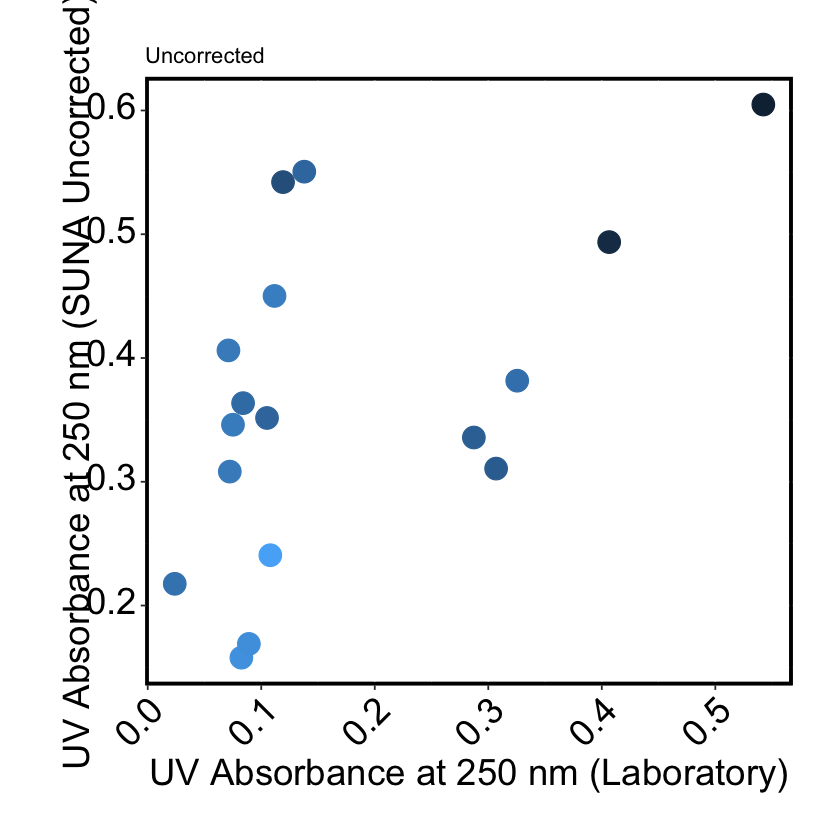

`geom_smooth()` using formula 'y ~ x'



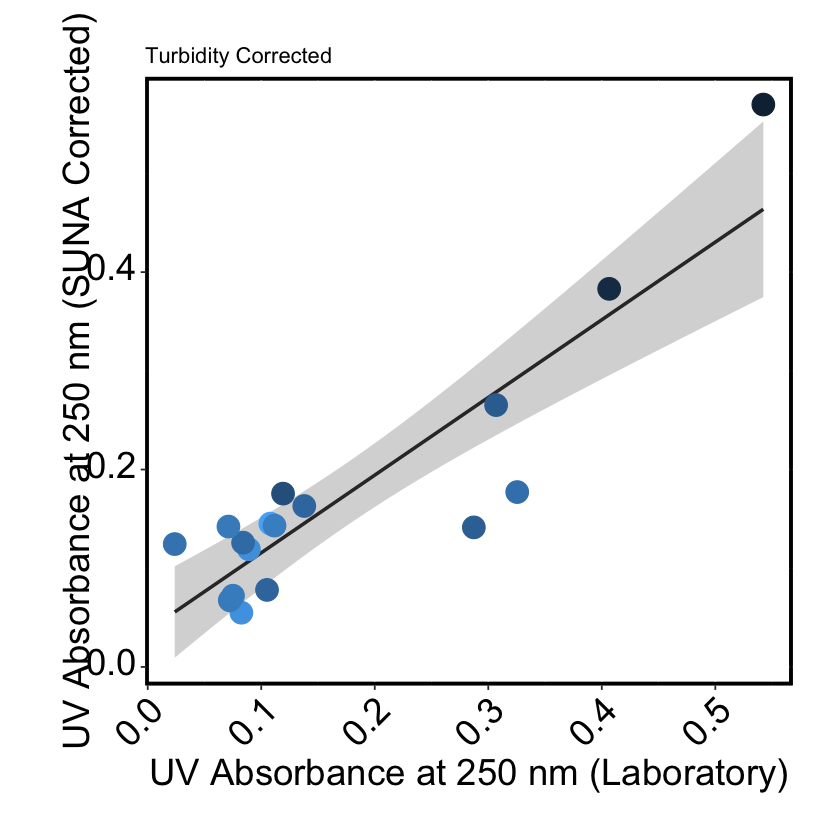

In [13]:
suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)


#summary(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))
#summary(lm(uva_250_lab~interp_250_c254.mean*turb_log,suna_grab))

suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))


ggplot(suna_grab,aes(uva_250_lab,interp_250_c254.mean,color=pH.mean))+
theme_ts_space+
xlab("UV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Uncorrected)")+
geom_point(size=6)+
ggtitle("Uncorrected")

ggsave("~/neon_suna/plots/CARI_250_uncorrected.pdf",width = 20, height = 20, units = "cm")



ggplot(suna_grab,aes(uva_250_lab,interp_250_tcorr_log,color=pH.mean))+
theme_ts_space+
geom_smooth(method="lm",color="grey20")+
xlab("UV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Corrected)")+
geom_point(size=6)+
ggtitle("Turbidity Corrected")

ggsave("~/neon_suna/plots/CARI_250_corrected.pdf",width = 20, height = 20, units = "cm")




#summary(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c350.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))

In [ ]:
names(CARI_sw)

# Apply turbidity correction based on lab samples.

In [14]:
cor_cols<-grep("^interp_",names(CARI_sw))

uva_250_turb_lm<-lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_250_log=log10(CARI_sw[,cor_cols[i]]),turbidity.mean=CARI_sw$turbidity.mean)
	turb_cor_pred<-predict(uva_250_turb_lm,newdata=prepdata)
	CARI_sw[,c(paste(names(CARI_sw)[cor_cols[i]],"_turb",sep=""))]<-turb_cor_pred
}



Warning message in data.frame(interp_250_log = log10(CARI_sw[, cor_cols[i]]), turbidity.mean = CARI_sw$turbidity.mean):
“NaNs produced”
Warning message in data.frame(interp_250_log = log10(CARI_sw[, cor_cols[i]]), turbidity.mean = CARI_sw$turbidity.mean):
“NaNs produced”
Warning message in data.frame(interp_250_log = log10(CARI_sw[, cor_cols[i]]), turbidity.mean = CARI_sw$turbidity.mean):
“NaNs produced”
Warning message in data.frame(interp_250_log = log10(CARI_sw[, cor_cols[i]]), turbidity.mean = CARI_sw$turbidity.mean):
“NaNs produced”
Warning message in data.frame(interp_250_log = log10(CARI_sw[, cor_cols[i]]), turbidity.mean = CARI_sw$turbidity.mean):
“NaNs produced”
Warning message in data.frame(interp_250_log = log10(CARI_sw[, cor_cols[i]]), turbidity.mean = CARI_sw$turbidity.mean):
“NaNs produced”
Warning message in data.frame(interp_250_log = log10(CARI_sw[, cor_cols[i]]), turbidity.mean = CARI_sw$turbidity.mean):
“NaNs produced”
Warning message in data.frame(interp_250_log = l

In [ ]:
head(CARI_sw)

In [15]:
CARI_swt_0<-CARI_sw[,grep("*_turb$",names(CARI_sw))]
CARI_swt<-bind_cols(CARI_sw[,c("dtpr","nitrate.mean","nitrate_mgl.mean","a254.mean","a350.mean","sensor_temp.mean","specificConductance.mean","dissolvedOxygen.mean","pH.mean","chlorophyll.mean","turbidity.mean","fDOM.mean")],CARI_swt_0)





# Adding PAR data.

In [17]:
CARI_par<-loadByProduct(dpID="DP1.20042.001",site="CARI",check.size=F)
saveRDS(CARI_par,paste(getwd(),"/CARI_par.rds",sep=""))
CARI_par<-readRDS(paste(getwd(),"/CARI_par.rds",sep=""))




Finding available files
  |======================================================================| 100%

  |======================================================================| 100%

Unpacking zip files using 1 cores.
Stacking operation across a single core.
Stacking table PARWS_1min
Stacking table PARWS_5min
Stacking table PARWS_30min
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 3 data tables and 1 metadata tables!
Stacking took 12.24961 secs


In [ ]:
str(CARI_par)

In [18]:

CARI_parts<-CARI_par$PARWS_5min
CARI_parts$dtp<-CARI_parts$startDateTime
#str(CARI_wqk)



CARI_parts$dtpr<-lubridate::round_date(CARI_parts$dtp, "15 minutes")
CARI_parts_red<-summaryBy(PARMean~dtpr,CARI_parts,FUN=c(mean))
head(CARI_parts_red)
#str(CARI_wq_red)

CARI_swtpar<-merge(CARI_swt,CARI_parts_red,by="dtpr",all.x=TRUE)


,dtpr,PARMean.mean
,<dttm>,<dbl>
1,2017-09-14 00:00:00,NA
2,2017-09-14 00:15:00,NA
3,2017-09-14 00:30:00,NA
4,2017-09-14 00:45:00,NA
5,2017-09-14 01:00:00,NA
6,2017-09-14 01:15:00,NA


In [19]:

str(CARI_swtpar$dtpr)

attr(CARI_swtpar$dtpr,"tzone") <- "Etc/GMT+5"

str(CARI_swtpar$dtpr)
CARI_swtpar$date<-as.Date(CARI_swtpar$dtpr,tz="Etc/GMT+5")

CARI_dates<-unique(CARI_swtpar$date)

for(i in 1:length(CARI_dates)){
    
    
}

 POSIXct[1:15627], format: "2019-05-08 00:00:00" "2019-05-08 00:15:00" "2019-05-08 00:30:00" ...
 POSIXct[1:15627], format: "2019-05-07 19:00:00" "2019-05-07 19:15:00" "2019-05-07 19:30:00" ...


In [20]:

#CARId<-subset(CARI_swtpar,date==as.Date("2019-06-10"))
CARId<-CARI_swtpar

CARIdk<-CARId[,grep("*c254.mean_turb$",names(CARId))]
CARIdk$dtpr<-CARId$dtpr

CARIdm<-subset(melt(CARIdk,id.vars=c("dtpr")),!is.na(value))
CARIdm$wavelength<-gsub("interp_","",CARIdm$variable,fixed=TRUE)
CARIdm$wavelength<-as.numeric(gsub("_c254.mean_turb","",CARIdm$wavelength,fixed=TRUE))



str(CARIdm)

'data.frame':	3026370 obs. of  4 variables:
 $ dtpr      : POSIXct, format: "2019-05-21 05:45:00" "2019-05-21 08:45:00" ...
 $ variable  : Factor w/ 206 levels "interp_189_c254.mean_turb",..: 10 10 10 10 10 10 10 10 10 10 ...
 $ value     : num  -0.0519 0.0323 0.0795 0.1021 0.0868 ...
 $ wavelength: num  198 198 198 198 198 198 198 198 198 198 ...


# Trying some ridge plots to look at wavelength changes over time.
So far not looking super great.

In [ ]:
library(ggridges)
#scales::rescale(height)
CARIdm$dtprn<-scales::rescale(as.numeric(CARIdm$dtpr))
CARIdm$abs<-scales::rescale(as.numeric(CARIdm$value))


ggplot(subset(CARIdm,wavelength>=275&wavelength<=295),aes(x = wavelength, y = dtprn, group=dtprn,height = abs)) +
  geom_ridgeline(fill="grey80",alpha=0.6)

ggsave("~/neon_suna/plots/CARIdm_ridge.pdf",width = 20, height = 40, units = "cm")


# Calculating spectral slope 275-295nm on each time step.

In [ ]:
names(CARId)
names(CARIdm)

In [21]:
ssm_275_295<-subset(CARIdm,wavelength>=275&wavelength<=295)
dtps<-unique(ssm_275_295$dtpr)
pb <- progress_bar$new(
	format = "  downloading [:bar] :percent eta: :eta",
	total = length(dtps), clear = FALSE, width= 60)
s275295_comp<-data.frame()


for(i in 1:length(dtps)){
	ssm_now<-subset(ssm_275_295,dtpr==dtps[i])
	
	ssm_now$am1<-ssm_now$value*100*2.3025851
	ssm_now$lnam1<-log(ssm_now$am1)


	if(sum(!is.na(ssm_now$lnam1))>2){
		s275295<-lm(ssm_now$lnam1~ssm_now$wavelength)$coefficients[2]*-1
		}else{s275295<-NA}
		s275295_temp<-data.frame(dtpr=dtps[i],s275295=s275295)
		s275295_comp<-bind_rows(s275295_comp,s275295_temp)
#		pb$tick()
}	
	


In [23]:
nrow(s275295_comp)
nrow(CARI_swtpar)
CARI_swtp_ss<-merge(CARI_swtpar,s275295_comp,by="dtpr",all.x=TRUE)
saveRDS(CARI_swtp_ss,paste(data,"CARI_swtp_ss.rds",sep=""))

[1] 15470

[1] 15627

# Extracting spectral daily slope ratio discrepancy.

In [24]:
sdates<-unique(as.Date(CARI_swtp_ss$dtpr,tz="Etc/GMT+5"))

#i<-30
comp_df<-data.frame()
for(i in 1:length(sdates)){
#print(i)
start<-as.POSIXct(paste(sdates[i]-1,"22:00",tz="Etc/GMT+5"))
finish<-as.POSIXct(paste(sdates[i]+1,"03:00",tz="Etc/GMT+5"))
CARIday<-subset(CARI_swtp_ss,dtpr>=start & dtpr<=finish)
CARIday<-subset(CARIday,!is.na(PARMean.mean) & !is.na(s275295))

if(nrow(CARIday)>80){
    CARIday$PAR_roll<-as.numeric(c("NA",rollmean(CARIday$PARMean.mean,k=3,align=c("center"),na.fill=TRUE),"NA"))
    CARIday$s275295_roll<-as.numeric(c("NA",rollmean(CARIday$s275295,k=3,align=c("center"),na.fill=TRUE),"NA"))



    CARI_night<-subset(CARIday,PARMean.mean<200)
    night_s275295<-mean(CARI_night$s275295,na.rm=TRUE)
    
    #CARIday$baseline<-predict(lm(s275295~dtpr,CARI_night),CARIday)
    CARIday$baseline_roll<-predict(lm(s275295_roll~dtpr,CARI_night),CARIday)    
    CARIday$s275295_bs<-CARIday$s275295_roll-CARIday$baseline_roll    
    
    CARI_night_am<-subset(CARI_night,hour(dtpr)<=12)
    night_s275295_am<-mean(CARI_night_am$s275295,na.rm=TRUE)
    
    CARI_night_pm<-subset(CARI_night,hour(dtpr)>12)
    night_s275295_pm<-mean(CARI_night_pm$s275295,na.rm=TRUE)
    
    CARI_day<-subset(CARIday,PARMean.mean>=10)
    day_s275295<-mean(CARI_day$s275295,na.rm=TRUE)

    day_s275295_base_sum<-sum(CARI_day$s275295_bs,na.rm=TRUE)
    day_PAR_roll_base_sum<-sum(CARI_day$PAR_roll,na.rm=TRUE)    

    int<-lm(s275295_bs~PAR_roll,CARI_day)$coef[1]
    slope<-lm(s275295_bs~PAR_roll,CARI_day)$coef[2]    
    
    CARI_n_am_time<-nrow(CARI_night_am)
    CARI_n_pm_time<-nrow(CARI_night_pm)
    CARI_d_time<-nrow(CARI_day)
    
    temp_df<-data.frame(site="CARI",date=sdates[i],night_s275295=night_s275295,night_s275295_am=night_s275295_am,night_s275295_pm=night_s275295_pm,day_s275295=day_s275295,day_s275295_base_sum=day_s275295_base_sum,day_PAR_roll_base_sum=day_PAR_roll_base_sum,int=int,slope=slope,CARI_n_am_time=CARI_n_am_time,CARI_n_pm_time=CARI_n_pm_time,CARI_d_time=CARI_d_time)
    comp_df<-bind_rows(comp_df,temp_df)
    }
}




Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(e

[1]            NA -7.006347e-05  5.760470e-05  6.346039e-05  7.930923e-05
 [6]  7.557515e-05  7.753695e-05  7.672116e-05  8.003527e-05  6.020796e-05
[11]  5.920119e-05  6.211661e-05  8.157420e-05  8.607634e-05  8.404628e-05
[16]  8.578311e-05  8.714614e-05  9.145062e-05  9.226678e-05  9.214917e-05
[21]  8.740876e-05  8.714419e-05  8.556337e-05  9.688747e-05  1.032568e-04
[26]  1.046195e-04  9.788990e-05  8.867984e-05  8.936814e-05  7.538613e-05
[31]  7.306692e-05  5.509539e-05  5.573587e-05  4.488109e-05  1.726554e-05
[36] -3.011043e-05 -5.550242e-05 -4.074811e-05  3.616688e-07

Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


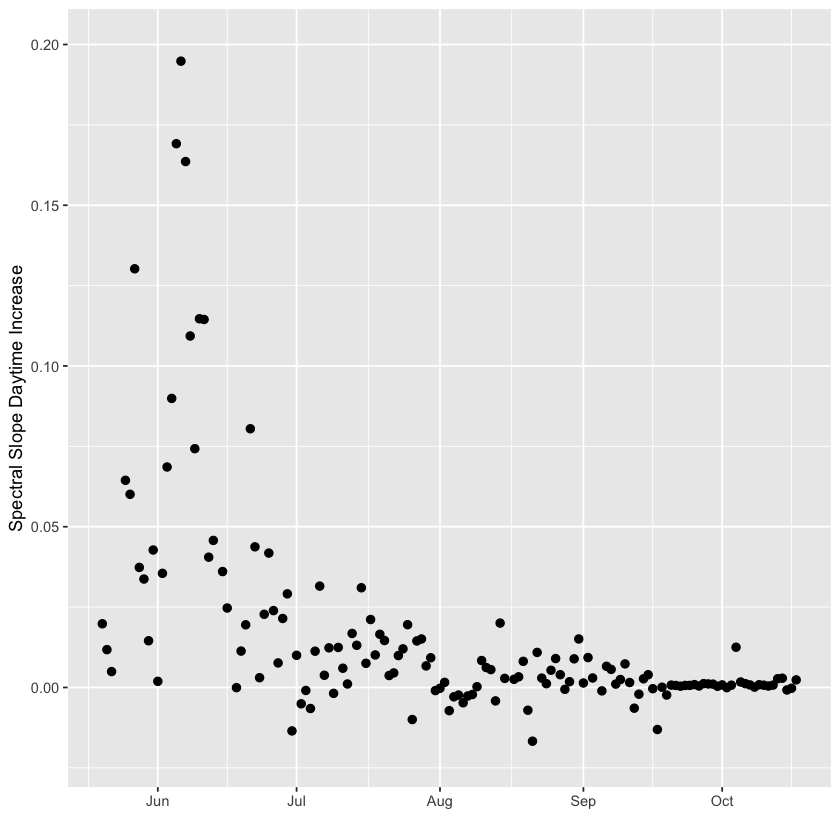

Warning message:
“Removed 6 rows containing missing values (geom_point).”


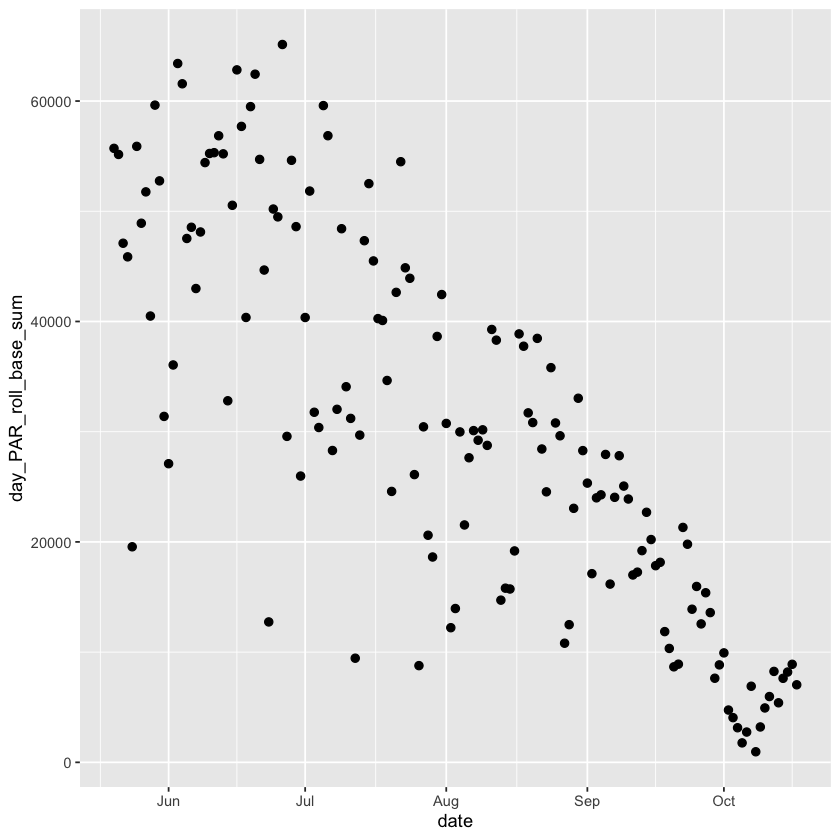

Warning message:
“Removed 6 rows containing missing values (geom_point).”


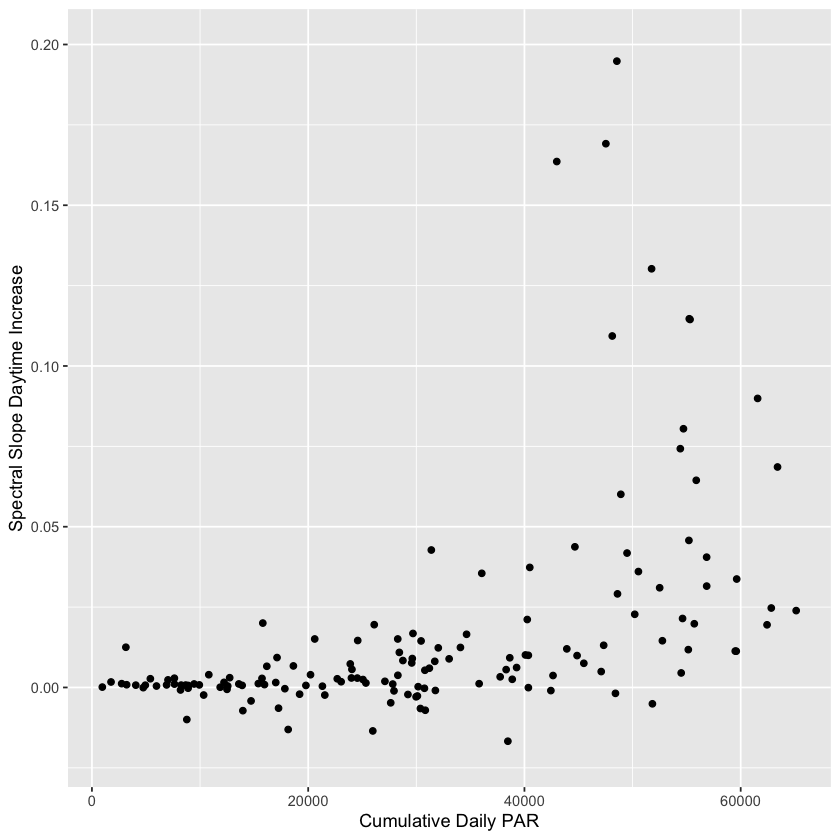

In [29]:
    CARI_day$s275295_bs
ggplot(comp_df,aes(date,day_s275295_base_sum))+
       geom_point(size=2)+
        xlab("")+
        ylab("Spectral Slope Daytime Increase")+
        ylim(c(-0.02,0.2))

ggsave("~/neon_suna/plots/CARI_del_s275295_date.pdf",width = 20, height = 20, units = "cm")

ggplot(comp_df,aes(date,day_PAR_roll_base_sum))+
       geom_point(size=2)


ggplot(comp_df,aes(day_PAR_roll_base_sum,day_s275295_base_sum))+
geom_point()+
        xlab("Cumulative Daily PAR")+
        ylab("Spectral Slope Daytime Increase")+
        ylim(c(-0.02,0.2))
ggsave("~/neon_suna/plots/CARI_del_s275295_par.pdf",width = 20, height = 20, units = "cm")

saveRDS(comp_df,paste(data,"comp_df_cari.rds",sep=""))

In [ ]:
CARIday<-subset(CARI_swtp_ss,as.Date(dtpr,tz="Etc/GMT+5")==as.Date("2019-06-11",tz="Etc/GMT+5"))
nrow(CARIday)

str(CARIday$s275295)



ggplot(CARIday,aes(dtpr,s275295))+
geom_point()


ggplot(CARIday,aes(dtpr,PARMean.mean))+
geom_point()

